In [203]:
import cv2
import numpy as np
import math as m
import matplotlib.pyplot as plt

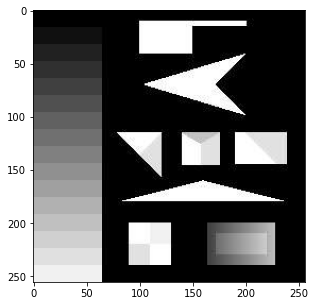

In [410]:
img = cv2.imread('images/Img3.png')
plt.figure(figsize=(5,5))
plt.imshow(img)

In [411]:
#Conversion is done based on the standard color to grayscale 
#conversion formula on Wikipedia i.e Y'=0.2627R'+ 0.6780G'+ 0.0593B'
def convert_to_greyScale(image):
    shape = image.shape
    
    #check if image is in rgb format
    if len(shape)==3:
        if shape[2] == 4:
            r, g, b, a= image[:,:,0], image[:,:,1], image[:,:,2], image[:,:,3]
            gray_img = 0.2989*r + 0.5870*g + 0.1140*b + 0.1*a
            return gray_img
        else:
            r, g, b= image[:,:,0], image[:,:,1], image[:,:,2]
            gray_img = 0.2989*r + 0.5870*g + 0.1140*b 
            return gray_img
    
    else:
        return image

In [412]:
def smooth_img(img):
    row,col = img.shape
    img_blur = np.zeros((row+4,col+4))
    sigma=1
    size=2
    #initialize the parameters for slicing
    row_slice = 5
    
    #gaussian filter of 5x5
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    gf =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    
    #convolve with the image but no need to
    #flip it because it is symmetric
    #1:Slice the image according to filter size
       #1:Slice the image according to filter size
    for i in range(row-4):
        col_slice= 5
        
        for j in range(col-4):
            img_slice = img[i:row_slice , j:col_slice]
            
            #2: convole and add the value into the corresonding derivative images
            img_blur[i+1, j+1] = sum(sum(img_slice*gf))
            
            #increment column slice size by 1
            col_slice = col_slice+1
            
        #increment the row slice by 1
        row_slice = row_slice+1
        
    return img_blur

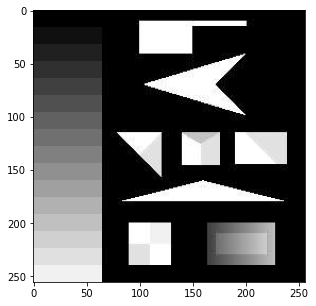

In [413]:
#convert ot grey scale with cv2
grey_img = convert_to_greyScale(np.copy(img))
#grey_img = smooth_img(grey_img)
plt.figure(figsize=(5,5))
plt.imshow(grey_img, cmap='gray')

In [414]:
#Calculate the gradiant of gaussian
def calculate_gradiant(sigma,x,y):
    #Given gaussian formula ----> G(x,y)=exp(-(x^2+y^2)/(2*sigma^2))
    #first derivative of above formula w.r.t x and  y
    fx = m.exp(-(x**2 + y**2)/(2*sigma**2)) * (x/(sigma**2))
    fy = m.exp(-(x**2 + y**2)/(2*sigma**2)) * (y/(sigma**2))
    return fx, fy

In [415]:
#function for calculating filter size
def calculate_filter_size(sigma,T):
    sHalf = round(m.sqrt(-m.log(T)*2*sigma**2))
    N = 2* sHalf+1
    return N, sHalf

In [416]:
def mask_generation(sigma):
    T = 0.3
    scale = 255
    Gfx = []
    Gfy = []
    
    #1: calculate filter size
    filter_size, sHalf = calculate_filter_size(sigma,T)
    
    #2: Generate filters
    x = np.arange(-sHalf,sHalf+1)
    y = np.arange(-sHalf,sHalf+1)
    X,Y = np.meshgrid(x,y)
    
    #3: generate gaussian kernal
    X_flatten = X.flatten()
    Y_flatten = Y.flatten()
    
    #calculate gradiant filters
    for x,y in zip(X_flatten, Y_flatten):
        fx,fy = calculate_gradiant(sigma,x,y)
        Gfx.append(fx*scale)
        Gfy.append(fy*scale)
    
    #4: Gx Gy are in list form, convert into matrix of filter_size x filter_size
    Gx = np.reshape(np.rint((np.array(Gfx))),(filter_size,filter_size))
    Gy = np.reshape(np.rint((np.array(Gfy))),(filter_size,filter_size))    
    #print(X,'\n\n',Y,"\n\n",Gx,"\n\n",Gy)
    return Gx,Gy

In [417]:
#convolution of gray scale Circle imgae with Gx and Gy

def convolution(img, grad_x, grad_y):
    #print(grad_x,'\n\n', grad_y)
    row,col = img.shape
    fx = np.zeros((row+2,col+2))
    fy = np.zeros((row+2,col+2))
    
    #get the size of filter to determine the range for traverse
    filter_size = grad_x.shape
    
    row = row-filter_size[0]+1
    col = col-filter_size[1]+1
    
    grad_x_flip = np.zeros((grad_x.shape))
    grad_y_flip = np.zeros((grad_y.shape))
    
    #variable for slicing the img matrix according to the kernal size, and increment it by 1 after each iteration
    row_slice= filter_size[0]
    
    #flip the filters in x and y direction but as they are 
    #gaussian so just flip them in the opposite axis only, i.e fx in y direction fy in x direction
    pos = 0
    for x in grad_x:
        r = x[::-1]
        grad_x_flip[pos] =r
        pos+=1
        
    #print(grad_x_flip)
    grad_y = np.flipud(grad_y)
    
    #1:Slice the image according to filter size
    for i in range(row):
        col_slice= filter_size[1]
        
        for j in range(col):
            img_slice = img[i:row_slice , j:col_slice]
            
            #2: convole and add the value into the corresonding derivative images
            fx[i+1, j+1] = sum(sum(img_slice*grad_x_flip))
            fy[i+1, j+1] = sum(sum(img_slice*grad_y))
            
            #increment column slice size by 1
            col_slice = col_slice+1
            
        #increment the row slice by 1
        row_slice = row_slice+1

    return fx,fy

In [418]:
# Mask genration sigma =0.5
Gx_5, Gy_5 = mask_generation(0.5)  
#print('sigma = 0.5 mask','\n', Gx_5,"\n\n",Gy_5,"\n")

#3: convolve with gaussian mask of 
#sigma= 0.5
fx_5, fy_5 = convolution(grey_img,Gx_5,Gy_5)

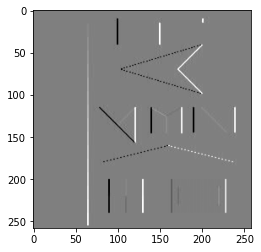

In [419]:
plt.imshow(fx_5, cmap='gray')

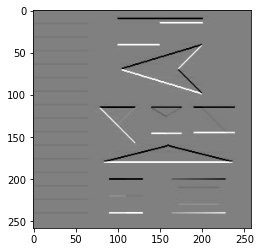

In [420]:
plt.imshow(fy_5, cmap='gray')

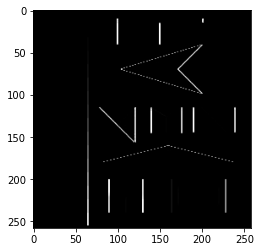

In [421]:
Ixx = fx_5*fx_5
plt.imshow(Ixx, cmap='gray')

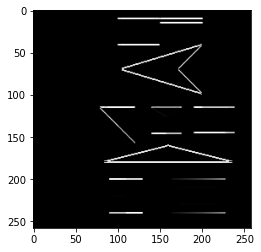

In [422]:
Iyy = fy_5*fy_5
plt.imshow(Iyy, cmap='gray')

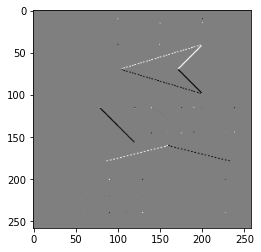

In [423]:
Ixy = fx_5*fy_5
plt.imshow(Ixy, cmap='gray')

In [424]:
#gaussian blur the derivatives
Ixx = smooth_img(Ixx)
Iyy = smooth_img(Iyy)
Ixy = smooth_img(Ixy)

In [425]:
k=0.04
detM = Ixx*Iyy - Ixy**2
traceM = Ixx+Iyy
R = detM - k*(traceM)**2

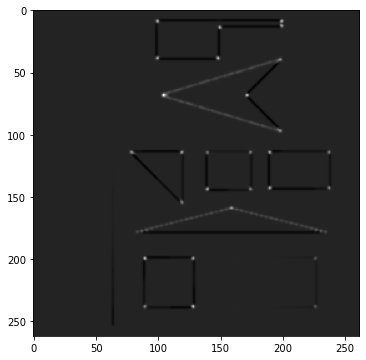

In [426]:
plt.figure(figsize=(6,6))
plt.imshow(R, cmap='gray')

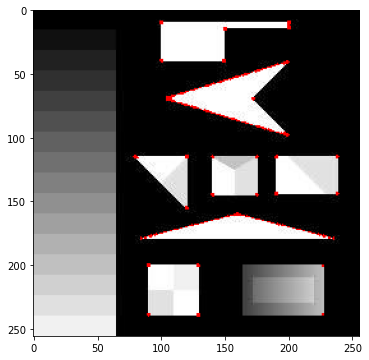

In [432]:
#corners selected such that a pixel is greater than the max lamda value or haris value* threshold
cornered_img = np.copy(img)
Haris_max = R.max()
thresh = 0.1
for i, row in enumerate(R):
    for j, pix in enumerate(row):
        if cornered_img.shape[2]==4:
            if pix >= Haris_max*thresh:
                cornered_img[i+1,j+1]=[255,0,0,1]
        else:
            if pix >= Haris_max*thresh:
                cornered_img[i+1,j+1]=[255,0,0]

plt.figure(figsize=(6,6))
plt.imshow(cornered_img)